In [1]:
import math
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [25]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import display, clear_output
%matplotlib inline


In [50]:
def mlp_layers(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        lin = nn.Linear(sizes[j], sizes[j + 1])
        with torch.no_grad():
            lin.weight.normal_(mean=0, std=np.sqrt(2/sizes[j]))
        nn.init.zeros_(lin.bias)
        layers += [lin, act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.ReLU):
        super().__init__()
        self.mlp = mlp_layers(layer_sizes, activation)

    def forward(self, X):
        return self.mlp(X)




In [54]:
def fit_model(
    model,
    optim,
    target,
    data_dim = 2,
    EPOCHS = 10,
    batches_per_epoch = 100,
    batch_size = 64,
    plot_fn = plot_residuals
):
    loss_list = []
    # param_list = []
    epoch=0
    plot_fn(model,loss_list,epoch)

    for i in range(EPOCHS*batches_per_epoch):
        support = 2*np.random.rand(batch_size,data_dim)-1

        support = (torch
            .as_tensor(support, dtype=torch.float32)
            .reshape(batch_size,1,data_dim)
            # .to(device)
        )

        y = target(support)

        yHat = model(support)

        loss = ((y - yHat)**2).sum()

        optim.zero_grad()
        loss.backward()
        optim.step()


        if np.isnan(loss.detach().cpu().item()):
            print("loss is nan")
            break

        loss_list.append(loss.detach().cpu().item())

        
        print(f"batch {i}, loss {loss}", end="\r")

        if (i+1) % batches_per_epoch ==0:
            plot_fn(model,loss_list,i)
        
    return model, loss_list

# 1d Case

In [60]:
class Plotter1d(object):
    def __init__(self, target_fn, Xs=None, jupyter=True):
        # self.model = model
        self.target_fn = target_fn

        if Xs is None:
            self.Xs = np.linspace(-1, 1, 100)
            self.support = (torch
                .as_tensor(self.Xs, dtype=torch.float32)
                .reshape(100,1,1)
        )

        fig, (axFit, axLoss) = plt.subplots(1, 2, figsize=(20, 5))

        self.fig = fig
        self.axFit = axFit
        self.axLoss = axLoss
        self.jupyter = True if jupyter else False

    def update_plot(self, model, loss_list, epoch, Xs=None):
        if loss_list==[]:
            loss_list=[0]
        self.fig.suptitle(f"batch {epoch}, loss {loss_list[-1]}", fontsize=14)

        # print(self.support)

        yHat = model(self.support).detach().cpu().numpy().flatten()

        Y = self.target_fn(self.support).detach().cpu().numpy().flatten()

        self.axFit.clear()
        self.axFit.plot(self.Xs, Y)
        self.axFit.plot(self.Xs, yHat)

        self.axLoss.clear()
        self.axLoss.plot(loss_list)
        self.axLoss.set_yscale("log")
        self.axLoss.set_yscale("log")


        if self.jupyter:
            clear_output(wait=True)
            display(self.fig)


# SGD

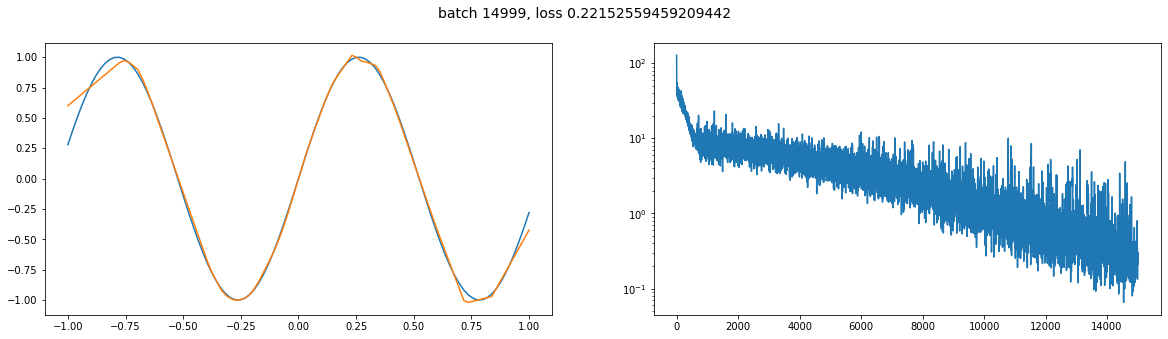

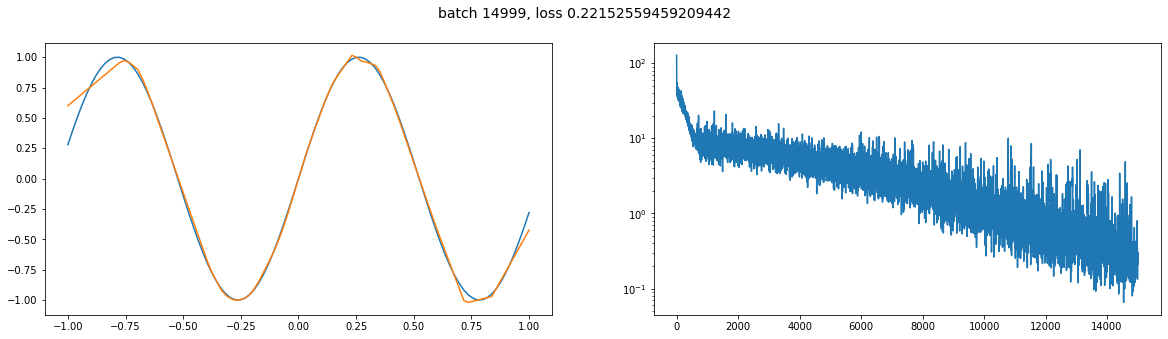

In [63]:
def f_torch_1d(x):
    return torch.sin(6*x)

plotter = Plotter1d(f_torch_1d)

model = MLP([1,80,40,20,1])

LR = 0.0001
optimizer = torch.optim.SGD(model.parameters(),lr=LR)

model2, loss_list = fit_model(
    model=model,
    optim=optimizer,
    target=f_torch_1d,
    data_dim = 1,
    EPOCHS = 150,
    batches_per_epoch = 100,
    batch_size = 100,
    plot_fn=plotter.update_plot
)


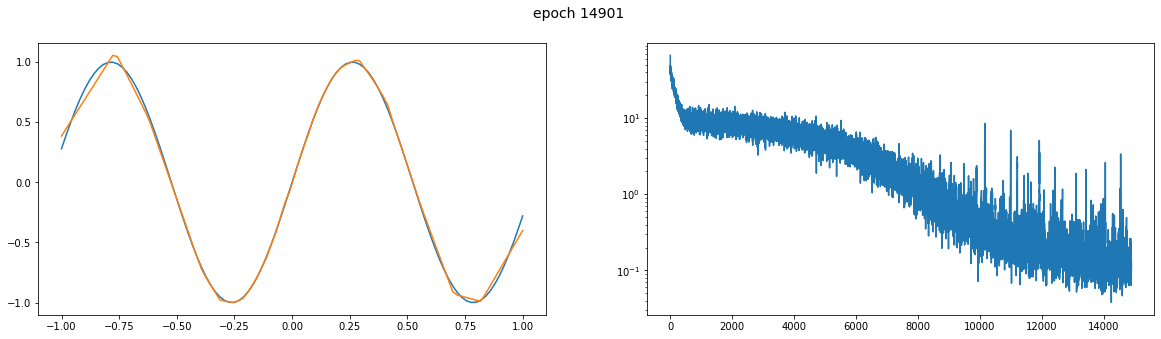

batch 14999, loss 0.10347042232751846

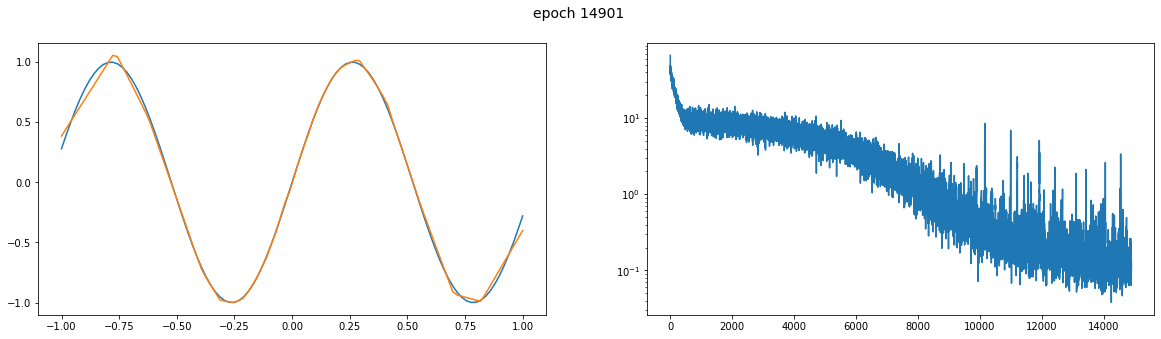

In [38]:
def f_torch_1d(x):
    return torch.sin(6*x)

plotter = Plotter1d(f_torch_1d)

model = MLP([1,80,40,20,1])

LR = 0.0001
optimizer = torch.optim.SGD(model.parameters(),lr=LR)

model2, loss_list = fit_model(
    model=model,
    optim=optimizer,
    target=f_torch_1d,
    data_dim = 1,
    EPOCHS = 150,
    batches_per_epoch = 100,
    batch_size = 100,
    plot_fn=plotter.update_plot
)


# ADAM OPTIMIZER

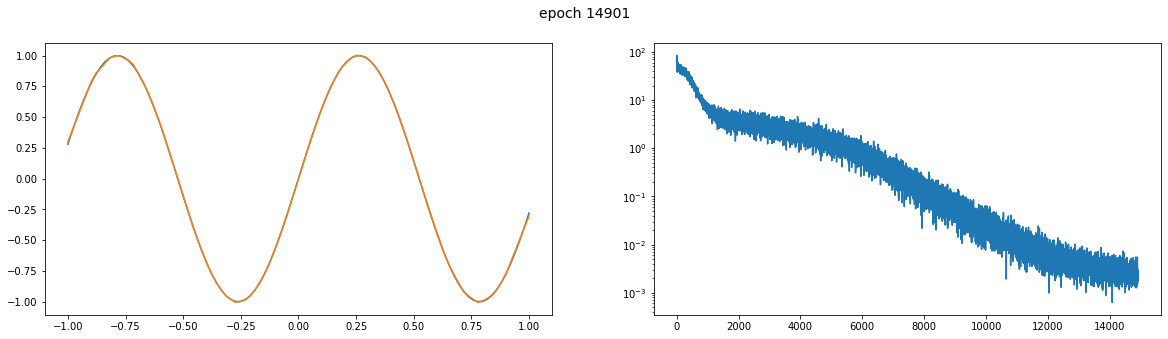

batch 14999, loss 0.0030754085164517164

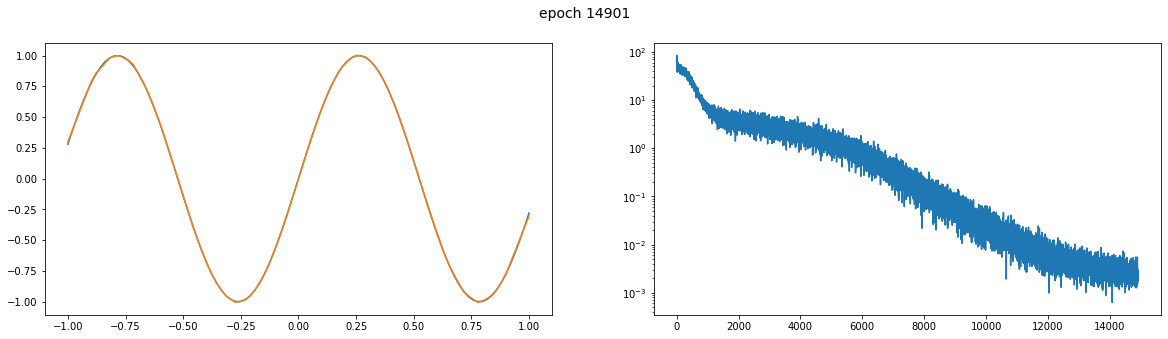

In [37]:
def f_torch_1d(x):
    return torch.sin(6*x)

plotter = Plotter1d(f_torch_1d)

model = MLP([1,80,40,20,1])

LR = 0.0001
# optimizer = torch.optim.SGD(model.parameters(),lr=LR)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

model2, loss_list = fit_model(
    model=model,
    optim=optimizer,
    target=f_torch_1d,
    data_dim = 1,
    EPOCHS = 150,
    batches_per_epoch = 100,
    batch_size = 100,
    plot_fn=plotter.update_plot
)


# 2d

In [4]:
# def f(x1, x2):
#     return np.sin(2+(x1-2)*10) * np.cos(2 + (x2) * (x1-1)*7) * np.cos(x1*x2*13)

def f(x1, x2):
    x1=(x1+1)/2 * 5
    x2=(x2+1)/2 * 5
    return np.sin(x1) ** 10 + np.cos(10 + x2 * x1) * np.cos(x1)


1.0510418316762058

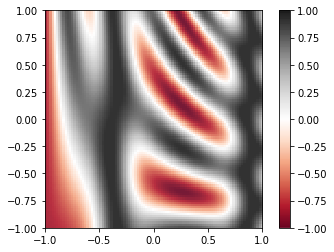

In [5]:
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1, X2 = np.meshgrid(x1,x2)
Y = f(X1, X2)

plt.imshow(Y, extent=[-1, 1, -1, 1], origin='lower',vmin=-1, vmax=1,
           cmap='RdGy', alpha=0.9)
plt.colorbar();

Y.max()

In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

model = MLP([2,80,40,20,1])
model.to(device)
count_vars(model)



4321

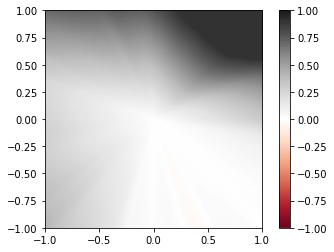

In [14]:
n_mesh=1000
x1 = np.linspace(-1, 1, n_mesh)
x2 = np.linspace(-1, 1, n_mesh)

X1, X2 = np.meshgrid(x1,x2)
data = np.vstack([X1.ravel(),X2.ravel()]).T


# for pytorch, input tensor is
# BATCH_SIZE * n_rows * n_cols
# -- nn.Linear does (x @ A + b) not (A @ x + b for some reason)
support = torch.as_tensor(data, dtype=torch.float32).reshape(n_mesh**2,1,2).to(device)

Y = model(support).detach().cpu().numpy().reshape(n_mesh,n_mesh)

plt.imshow(Y, extent=[-1, 1, -1, 1], origin='lower',vmin=-1, vmax=1,
           cmap='RdGy', alpha=0.9)
plt.colorbar();



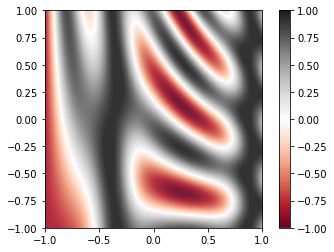

In [9]:
n_mesh=1000
x1 = np.linspace(-1, 1, n_mesh)
x2 = np.linspace(-1, 1, n_mesh)

X1, X2 = np.meshgrid(x1,x2)
data = np.vstack([X1.ravel(),X2.ravel()]).T
support = torch.as_tensor(data, dtype=torch.float32).reshape(n_mesh**2,1,2).to(device)


def f_torch(X):
    x1=(X[:,:,0]+1)/2 * 5
    x2=(X[:,:,1]+1)/2 * 5
    return torch.sin(x1) ** 10 + torch.cos(10 + x2 * x1) * torch.cos(x1)
# Yhat = mlp(torch.as_tensor(support, dtype=torch.float32).reshape(n_mesh**2,1,2).to(device))

Y=f_torch(support).detach().cpu().numpy().reshape(n_mesh,n_mesh)

plt.imshow(Y, extent=[-1, 1, -1, 1], origin='lower',vmin=-1, vmax=1,
           cmap='RdGy', alpha=0.9)
plt.colorbar();



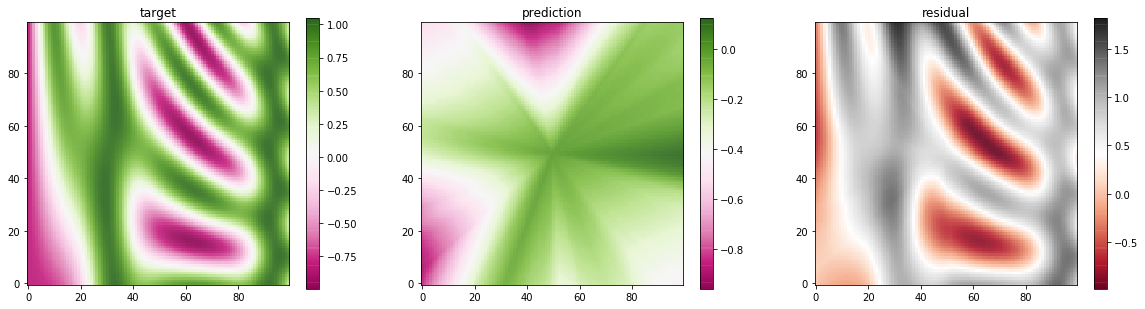

In [10]:
def plot_residuals(model, loss_list=None, n_mesh=100):
        
    x = np.linspace(-1, 1, n_mesh)
    y = np.linspace(-1, 1, n_mesh)

    X, Y = np.meshgrid(x, y)
    gridshape = X.shape
    with torch.no_grad():
        support = np.vstack([X.ravel(),Y.ravel()]).T
        support = (torch
                .as_tensor(support, dtype=torch.float32)
                .reshape(n_mesh**2,1,2)
        )

        yHat = model(support).detach().cpu().numpy().reshape(n_mesh,n_mesh)

        Y = f_torch(support).detach().cpu().numpy().reshape(n_mesh,n_mesh)

        Z = Y - yHat

    fig, (ax1, axYhat, ax2) = plt.subplots(1,3,figsize=(20,5))

    cbar1 = ax1.imshow(Y , origin='lower',
            cmap='PiYG', alpha=0.9)
    # ax1.colorbar();
    ax1.set_title("target")
    fig.colorbar(cbar1, ax=ax1)

    cbarYhat = axYhat.imshow(yHat , origin='lower',
            cmap='PiYG', alpha=0.9)
    axYhat.set_title("prediction")
    fig.colorbar(cbarYhat, ax=axYhat)

    cbar2 = ax2.imshow(Z, origin='lower',
            cmap='RdGy', alpha=0.9)
    ax2.set_title("residual")
    fig.colorbar(cbar2, ax=ax2)
    plt.show()

plot_residuals(model)



In [6]:
model = MLP([2,180,40,20,1])

LR = 0.0001
# optimizer = torch.optim.SGD(model.parameters(),lr=LR)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

model2, loss_list = fit_model(
    model=model,
    optim=optimizer,
    target=f_torch,
    EPOCHS = 20,
    batches_per_epoch = 1000,
    batch_size = 1000,
)
